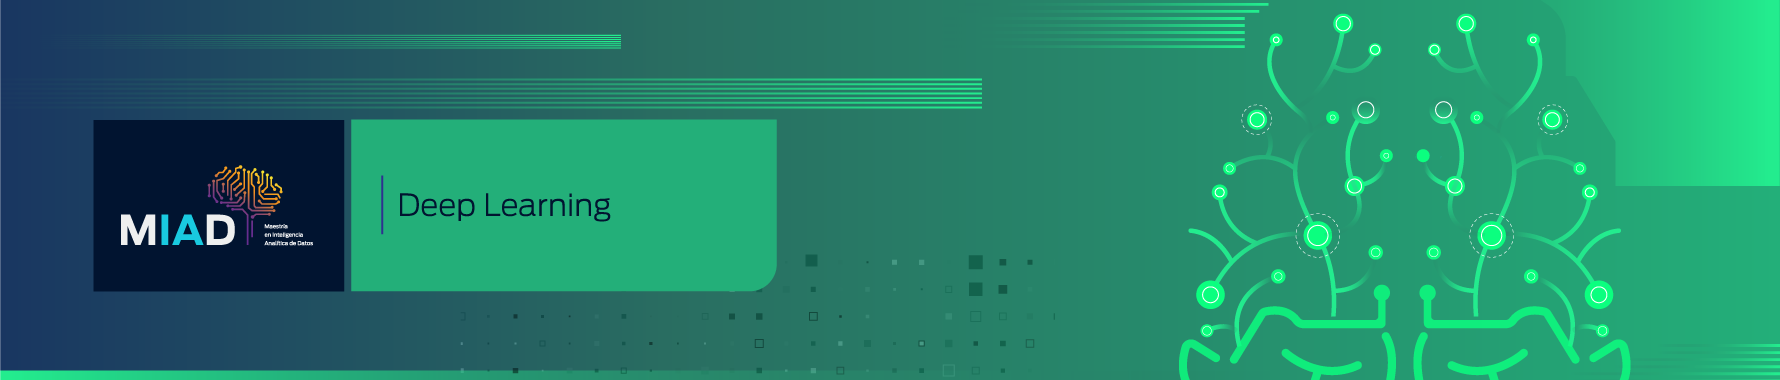

# Deep learning - Semana 7
## Aplicación de LSTM (Long Short-Term Memory) a predicción de series de tiempo

### Propósito

En esta actividad se revisará la aplicación del modelo LSTM utilizando el paquete _Keras_, sus características principales y se implementarán los pasos necesarios para la predicción de una serie de tiempo. Finalmente, habrá una actividad calificada sobre un conjunto de datos donde deberá proponer una red LSTM.

### Instrucciones generales

1. Cuando se le solicite declarar una estructura de datos debe usar el nombre exigido.
2. Utilice estrictamente los tipos de datos y nombres de variable indicadas en los enunciados de los ejercicios.
3. Evite crear, eliminar o modificar celdas de este notebook (salvo lo que se le indique) pues puede afectar el proceso de calificación automático.  

### Definición de la red

El análisis de series de tiempo es un problema complejo debido a la dependencia secuencial que existe en las variables de entrada, esto quiere decir que, un dato particular está relacionado con los del pasado de distintas maneras. Estas dependencias pueden ser de largo plazo, lo cual es un impedimento importante para las RNN simples/tradicionales, ya que al tratar de considerar influencias extensas se presenta el problema del gradiente explosivo/desvaneciente. Las redes LSTM logran superar esta limitante utilizando bloques de memoria conectadas en capas a cambio de neuronas. En la siguiente imagen se observa el esquema de un bloque de memoria LSTM:

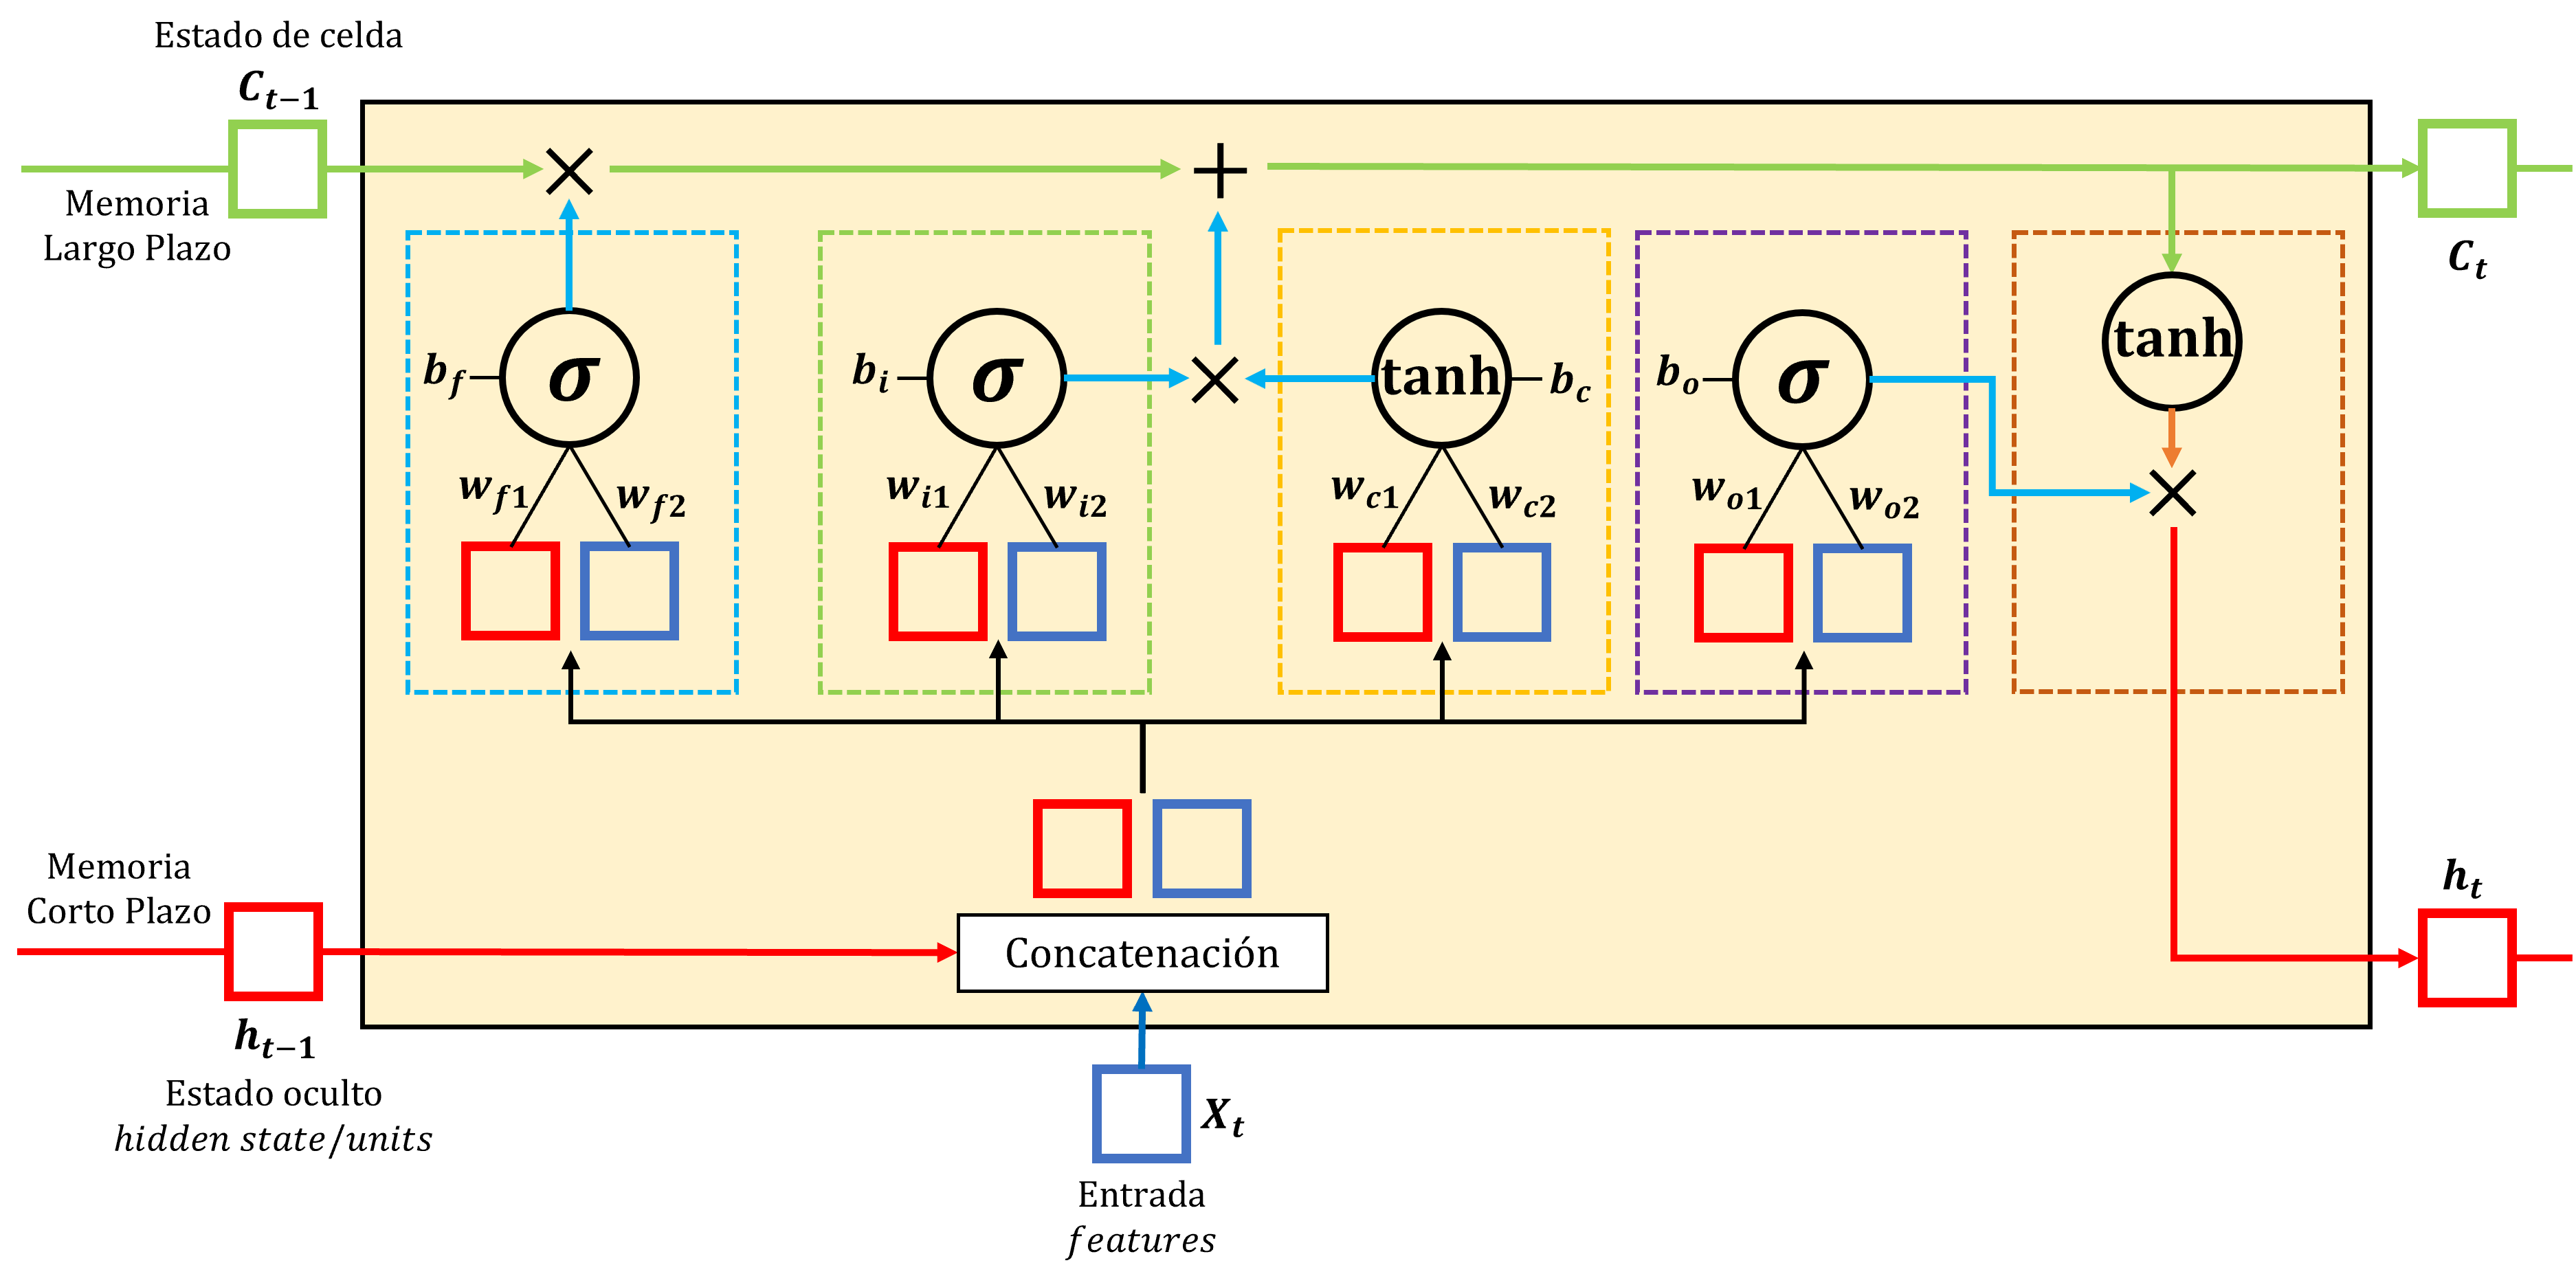

Un bloque de LSTM posee una serie componentes que lo hacen más efectivo que una red tradicional. En primer lugar, maneja dos estados que representan la memoria a corto plazo (estado oculto $h_{t-1}$) y la memoria a largo plazo (estado de celda $C_{t-1}$). LSTM se encargará de actualizar ambos estados utilizando el valor de entrada de la secuencia $X_t$ y una serie de puertas (_gates_) que deciden en qué medida una predicción $h_t$ es afectada por valores anteriores de corto y largo plazo.

En este modelo, los pesos y sesgos entrenados corresponden a los de las puertas, donde cada una de ellas cumple una función diferente. Siguiendo el esquema anterior tenemos:
*   **Una puerta del olvido _(Forget Gate)_:** Consiste en un sub-bloque que decide el porcentaje de la información de largo plazo que es conservada en el estado de celda a través de una función sigmoide. Note que el resultado de esta puerta multiplica el estado de celda anterior $C_{t-1}$.
*   **Una puerta de entrada _(Input Gate)_:** Los siguientes dos sub-bloques deciden la información de entrada y corto plazo que es almacenada en la memoria de largo plazo. Para lograr esto, el primer sub-bloque determina el porcentaje de información que se busca recordar utilizando una función sigmoide, mientras el segundo sub-bloque envía la información a recordar a través de una función tangente hiperbólica. Note que los resultados de ambos sub-bloques se multiplican para luego ser sumados a la memoria de largo plazo.
*   **Una puerta de salida _(Output Gate)_:** Los últimos dos sub-bloques deciden la información de largo plazo que será almacenada como memoria de corto plazo. En este caso, el primer sub-bloque determina el porcentaje de información que se busca recordar utilizando una función sigmoide y usa la información de entrada y la memoria de corto plazo anterior; mientras, el segundo sub-bloque envía la información de largo plazo a recordar a través de una función tangente hiperbólica. Los resultados de ambos sub-bloques se multiplican para obtener el _output_ del bloque, es decir, la predicción del siguiente dato. Es importante notar que el último sub-bloque no tiene pesos ni sesgos a entrenar.

Se puede observar en esta arquitectura básica de LSTM que, para cada uno de los primeros 4 sub-bloques, tenemos dos pesos y un sesgo, lo cual da un total para todo el bloque de 8 pesos y 4 sesgos. Esta red LSTM se puede entrenar recursivamente con todos los datos de la serie de tiempo como se indica en el siguiente esquema:





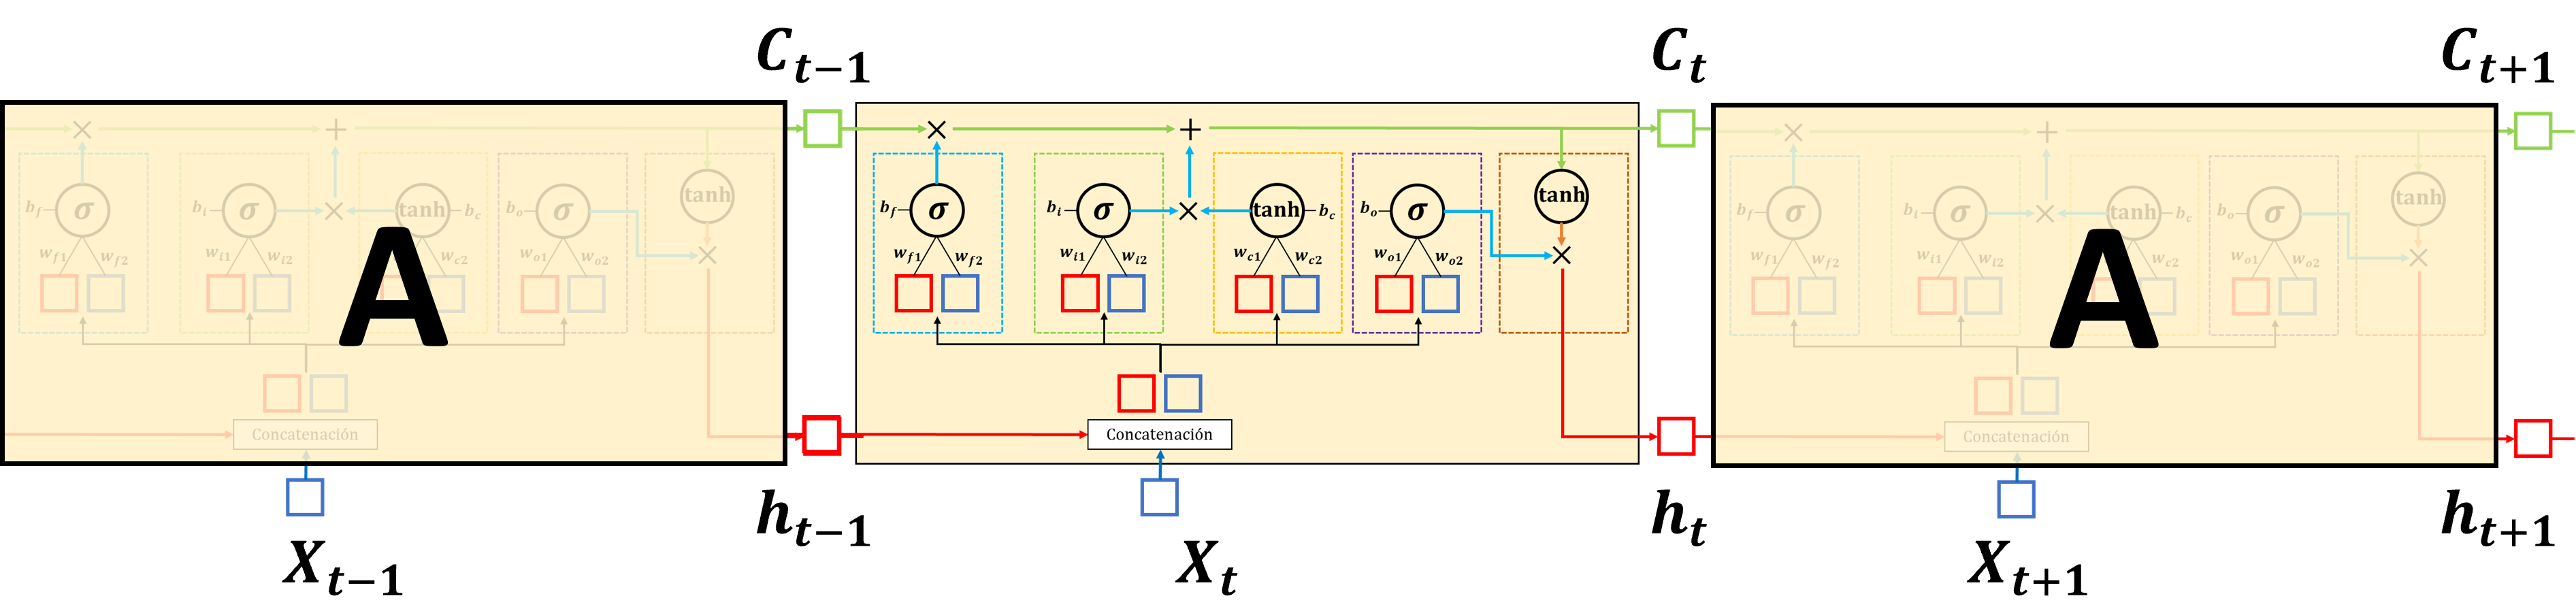

### Implementación en Keras/Tensorflow

Para interactuar con los diferentes componentes de la red, implementaremos LSTM utilizando la capa que ofrece _Keras_ mediante la aplicación en un ejemplo. En primer lugar, importaremos las librerías requeridas:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#Las siguientes dos líneas evitan la generación de "warnings" y "flags" al importar keras y tensorflow.
#Dichas advertencias no comprometen el funcionamiento del código.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#Importación de keras y tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

Aplicaremos la red sobre una serie de tiempo que representa la generación de electridad neta mensual medida en billones de kilowatts hora (kWh) en los Estados Unidos (datos tomados de la Administración de Información Energética de Estados Unidos):

In [ ]:
# Se carga el conjunto de datos
dataframe = pd.read_csv('usmelec.csv', usecols=[1])
# Se observan los primeros datos
print(dataframe.head())
# Gráfica de la serie
plt.figure(figsize=(10,5))
plt.plot(dataframe)
plt.show()

Estos datos tiene una clara tendencia creciente, no sólo en el promedio sino en la varianza de la serie. Una práctica común al entrenar un modelo para predicción de series de tiempo es estacionalizar los datos. Sin embargo, pondremos a prueba la red LSTM sin realizar esta transformación de los datos.

Por otro lado, hay una transformación que sí es necesaria para redes LSTM: el escalado de los datos. Debido a que estamos trabajando con funciones sigmoide y tangente hiperbólica, es esencial que los datos se reajusten al rango entre 0 y 1:

In [ ]:
dataset = dataframe.values
dataset = dataset.astype('float32')
#Se reescala la serie de tiempo
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_rescaled = scaler.fit_transform(dataset)
#Gráfica de la serie
plt.figure(figsize=(10,5))
plt.plot(dataset_rescaled)
plt.show()

A continuación, se dividirá la serie en una parte inicial para entrenamiento (60%) y una parte final de prueba (40%). Con esta partición, probaremos la capacidad de LSTM para predecir la serie a futuro:

In [ ]:
train_percent = 0.6
train_size = int(len(dataset_rescaled) * train_percent)
test_size = len(dataset_rescaled) - train_size
train, test = dataset_rescaled[0:train_size,:], dataset_rescaled[train_size:len(dataset),:]
print("Cantidad de datos para entrenamiento: ",len(train))
print("Cantidad de datos para prueba: ",len(test))

El problema de predicción (_forecast_) consiste en la estimación del siguiente valor de la serie de tiempo, en este caso, dada la generación de energía en un mes, se busca predecir el valor del siguiente mes. Para entrenar la red LSTM, debemos convertir el conjunto de datos en un problema de aprendizaje supervisado, donde un dato del pasado busca predecir al siguiente. Para esto, creamos una nueva columna donde los datos son desplazados una posición (esto es, un rezago o _lag_ igual a 1), con lo cual se busca que la primera columna sea predicha por la segunda. La siguiente función permite generar varias columnas dependiendo de la cantidad de lags que se quieran analizar, lo cual nos servirá más adelante:

In [ ]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

Se aplica la función a los sets de entrenamiento y prueba:

In [ ]:
lag=1
train_supervised, test_supervised = timeseries_to_supervised(train, lag), timeseries_to_supervised(test, lag)
print(train_supervised)

Nótese que es inevitable la generación de un `NaN` debido a que el primer dato no tiene un dato predecesor con el cual se pueda comparar. Esto se tiene en cuenta en los siguientes cambios de dimensiones de los datos al incluir la variable `lag`:

In [ ]:
train_values, test_values = train_supervised.values[lag:,:], test_supervised.values[lag:,:]

train_values = train_values.reshape(train_values.shape[0], train_values.shape[1])
test_values = test_values.reshape(test_values.shape[0], test_values.shape[1])

trainX, trainY = train_values[:, 0:-1], train_values[:, -1]
testX, testY = test_values[:, 0:-1], test_values[:, -1]

# [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], lag, 1)
testX = testX.reshape(testX.shape[0], lag, 1)

Las sucesivas transformaciones realizadas anteriormente son requeridas por la red LSTM en el siguiente orden: en la primera dimensión están la cantidad de muestras $(X_{t-1},X_{t})$, en la segunda el número de lags, y en la tercera los _features_ a predecir, que en este caso es **un** dato en el futuro.

Antes de establecer los parámetros de la red neuronal, hay que ser conscientes de que los pesos obtenidos luego de entrenar el modelo cambian dependiendo de la inicialización de los pesos. La consecuencia de esto es que, cada vez que se crea, compila y entrena una red, el desempeño será diferente en cada ejecución a pesar de usar los mismos hiperparámetros. Este comportamiento estocástico dificulta la decisión respecto a cuáles son los hiperparámetros apropiados para solucionar un problema con una red neuronal. Existen dos soluciones para esto:
*   Entrenar varias veces el mismo modelo y guardar una lista con las métricas de desempeño en test (por ejemplo, RMSE) de cada entrenamiento. Luego, se promedian los resultados y se decide el desempeño del modelo con este resultado (también se puede obtener un intervalo de confianza). El problema con esta opción es que implica mucho tiempo computacional, ya que requiere hacer varios entrenamientos para una sola combinación de hiperparámetros.
*   Hacer un solo entrenamiento fijando una semilla con la función `tf.keras.utils.set_random_seed` justo antes de la creación de un modelo de red neuronal. Al hacer esto, garantizamos la reproducibilidad, es decir, que los valores de los pesos serán inicializados de la misma manera siempre que se use el mismo valor de semilla, de manera que luego del entrenamiento se obtendrán los mismos pesos. En este caso, el valor de la semilla se puede tratar como un hiperparámetro más, o se puede fijar y explorar únicamente los hiperparámetros propios de la red. En este notebook, utilizaremos esta última opción para evitar realizar un gran número de entrenamientos.

In [ ]:
semilla=4269
tf.keras.utils.set_random_seed(semilla)

A continuación, definamos una red básica LSTM, la cual tendrá sólo una unidad oculta que se conecta a la neurona de salida con activación lineal. Se utilizará como función de pérdida el _Mean Squared Error_, tamaño de batch de 1 y un _Early Stopping_ con paciencia de 10 que nos servirá en caso que el entrenamiento haya convergido tempranamente:

In [ ]:
hidden_units = 1
batch_size = 1
model = Sequential()
model.add(LSTM(hidden_units, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model.summary()

En el sumario del modelo podemos confirmar que tenemos sólo 12 parámetros entrenables en el bloque LSTM: 8 pesos y 4 sesgos. Entrenemos el modelo:

In [ ]:
history=model.fit(trainX, trainY, epochs=100, batch_size=batch_size, verbose=2, callbacks=[callback])

A modo de ilustración, observemos los pesos del modelo:

In [ ]:
model.get_weights()

El primer arreglo corresponde a los pesos relacionados con los inputs/features (cuadro azul en el esquema mostrado a inicios del notebook); el segundo arreglo corresponde a los pesos relacionados con las unidades ocultas (cuadro rojo en el esquema mostrado a inicios del notebook). El tercer arreglo presenta los sesgos de los _gates_.

Observemos la evolución de la función de pérdida:

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')

El entrenamiento del modelo convergió, con lo cual podemos realizar predicciones sobre el conjunto de prueba y probar su efectividad con la métrica RMSE:

In [ ]:
# Se realizan predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
# Se devuelve el escalado de las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Se calcula RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Para contextualizar el desempeño de la red, grafiquemos la serie original (línea azul) contra la serie resultante del entrenamiento (línea naranja) y la predicha con el set de prueba:

In [ ]:
# Se ingresan predicciones de train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# Se ingresan predicciones de test
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lag*2):len(dataset), :] = testPredict
# Se grafican las series
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Se puede observar que, gráficamente, la serie predicha sigue la tendencia creciente pero tiene problemas en los valores pico. Aún podemos mejorar bastante la red en las siguientes secciones, en las que probaremos el cambio de algunos hiperparámetros para hacer la red más compleja y revisar mejora del desempeño en términos de RMSE.

### LSTM con varias unidades ocultas

Así como en una red neuronal tradicional se pueden agregar más neuronas a una capa para aumentar el número de pesos a entrenar, es posible aumentar el número de parámetros de forma equivalente en LSTM. El número de total de parámetros depende de la cantidad de _features_ en el input y la cantidad de _hidden units_ establecidas en el modelo. Las _hidden units_ son el equivalente al número de neuronas en una capa: ilustremos cómo cambiaría el número de pesos en el siguiente esquema con 2 unidades ocultas:

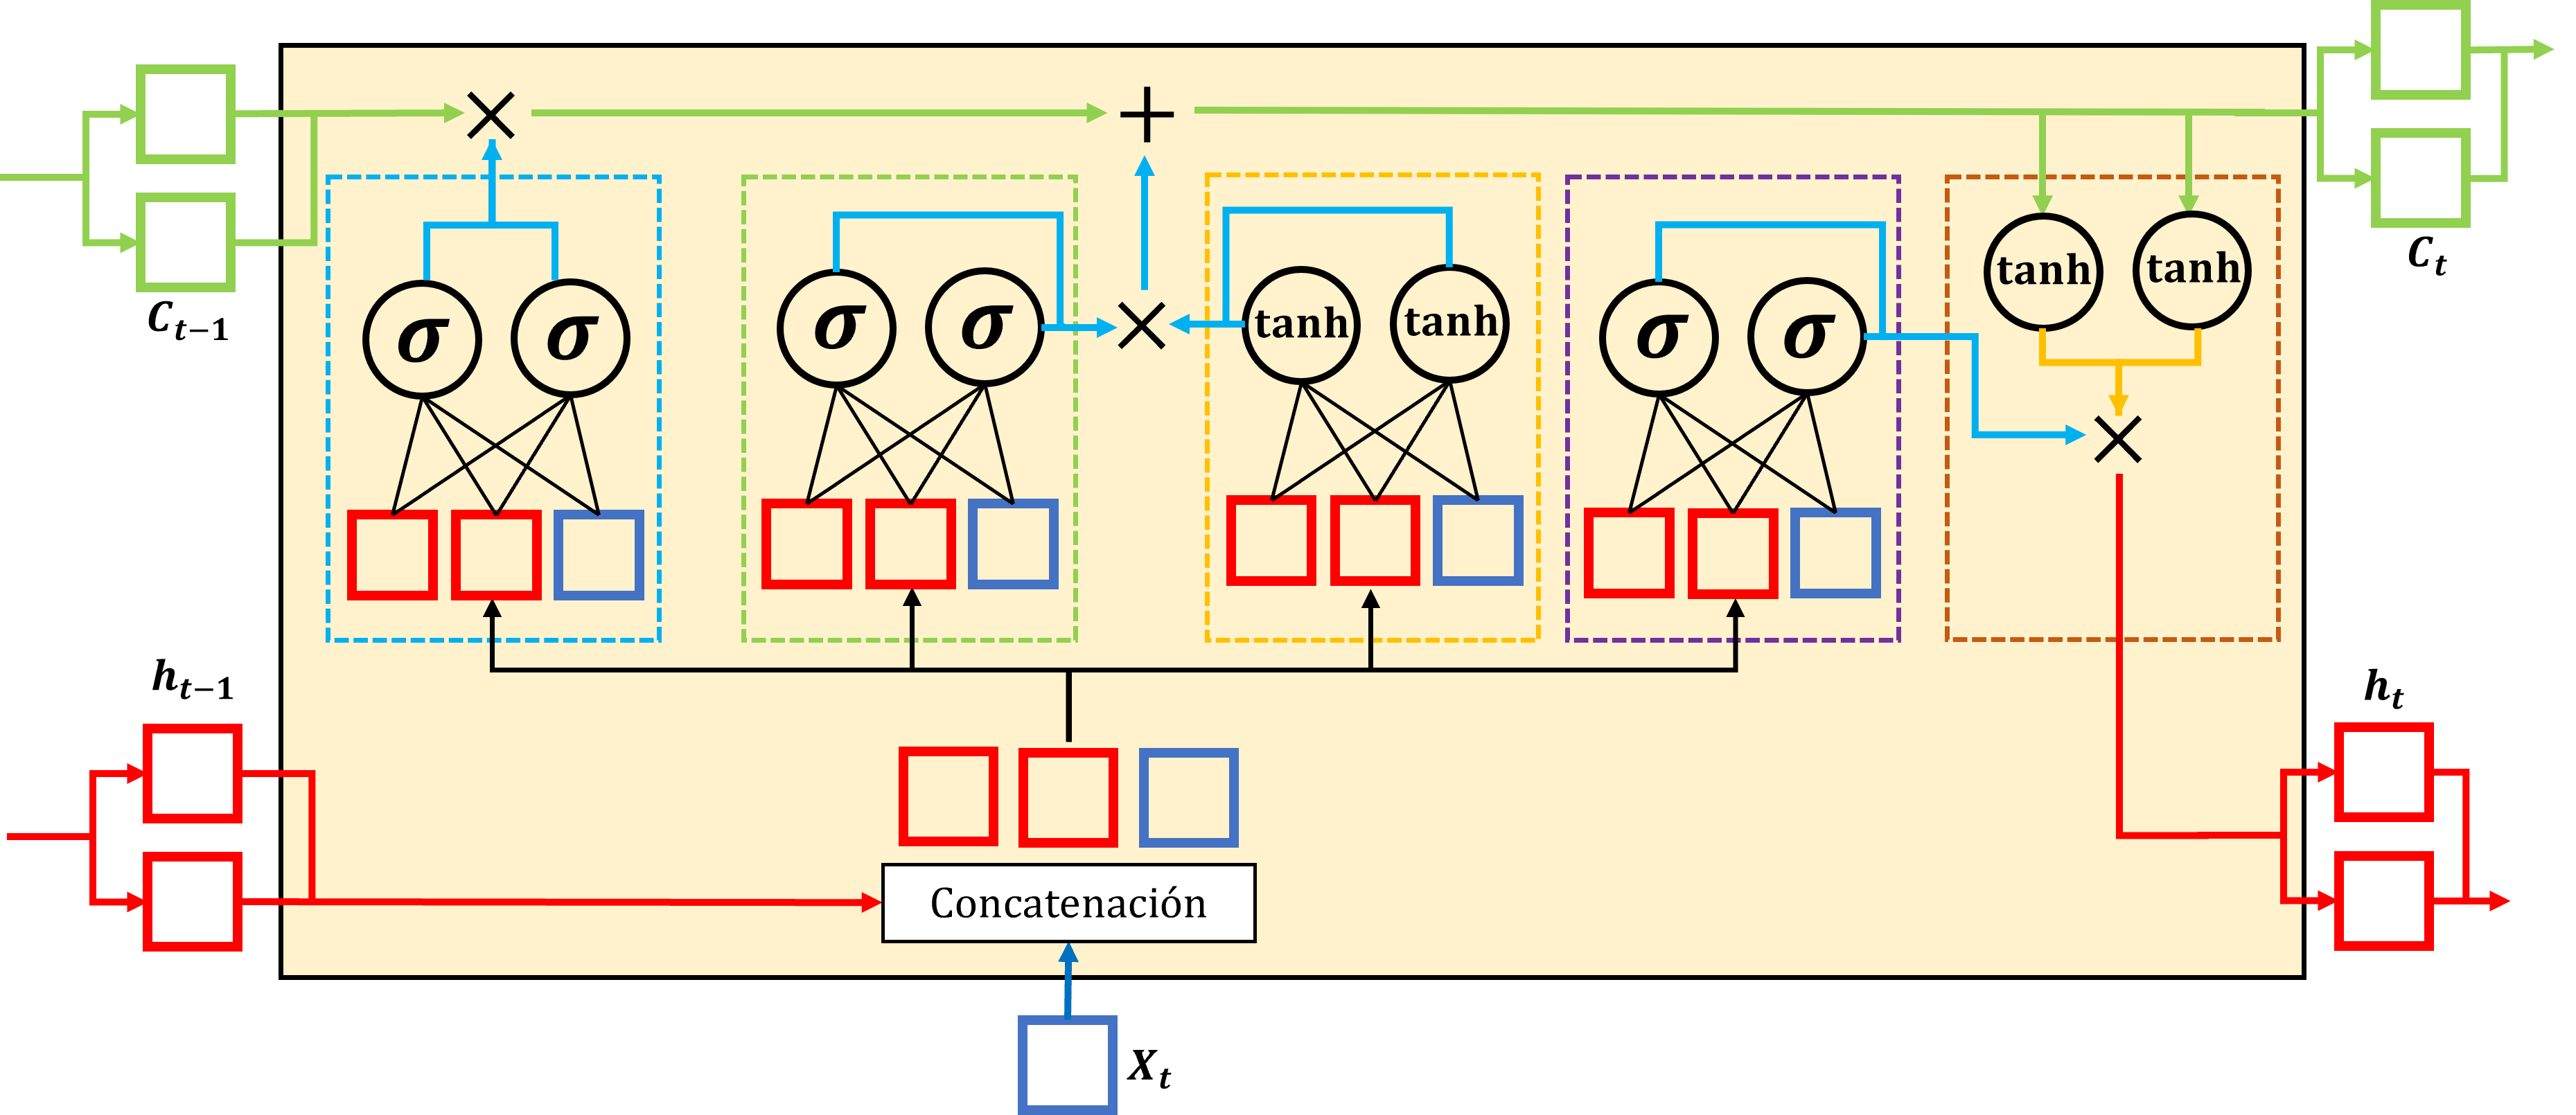

Note que al aumentar las _hidden units_, no sólo aumenta la dimensión de los vectores $h$ y $C$, sino que también lo hacen las neuronas de cada _gate_. Como resultado, como el vector concatenado tiene dimensión 3 (1 feature + 2 hidden units) y dos neuronas por puerta, se tiene un total de 6 pesos por _gate_. A esto se suma un sesgo por neurona, lo cual nos da un total de 8 parámetros por puerta y un total $8\times 4 = 32$ parámetros entrenables para esta nueva red LSTM. Generalizando, se puede decir que para $x$ features y $h$ hidden units, el total de parámetros es igual a $4\times ((x+h)\times h+h)$.

Evaluemos esta red con la serie de datos de aplicación:

In [ ]:
# Preparación de datos
trainX, trainY = train_values[:, 0:-1], train_values[:, -1]
testX, testY = test_values[:, 0:-1], test_values[:, -1]
# [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], lag, 1)
testX = testX.reshape(testX.shape[0], lag, 1)

#Se fija la semilla
tf.keras.utils.set_random_seed(semilla)
#Modelo LSTM
hidden_units = 2
batch_size = 1
model = Sequential()
model.add(LSTM(hidden_units, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model.summary()

Podemos verificar que el número de parámetros entrenables en LSTM es 32. Ahora realicemos el entrenamiento:

In [ ]:
history=model.fit(trainX, trainY, epochs=100, batch_size=batch_size, verbose=2, callbacks=[callback])

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')

In [ ]:
# Se realizan predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
# Se devuelve el escalado de las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Se calcula RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# Se ingresan predicciones de train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# Se ingresan predicciones de test
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lag*2):len(dataset), :] = testPredict
# Se grafican las series
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Compare el RMSE de este modelo con el anterior, ¿mejoró?. Es importante recordar que el resultado del entrenamiento varía debido a la estocasticidad inherente del problema, por lo que es posible que obtenga un resultado a veces mejor, a veces peor. En nuestro caso, dependerá del valor de la semilla.

### Uso de pasos de tiempo en redes LSTM

Hasta este momento, hemos utilizado LSTM considerando un problema de aprendizaje supervisado con un rezago (lag) igual a 1. Sin embargo, es posible tener en cuenta dependencias temporales mayores aumentando el valor del lag utilizando **pasos de tiempo** (`timesteps`). Por ejemplo, dado que tenemos datos mensuales, se puede predecir lo que sucederá en un mes (_feature_ igual a 1) teniendo en cuenta siempre el año anterior (últimos 12 meses), y así identificar características periódicas de la serie de tiempo. Generemos una base de datos con lag 12 utilizando la función `timeseries_to_supervised`:

In [ ]:
lag=12
train_supervised, test_supervised = timeseries_to_supervised(train, lag), timeseries_to_supervised(test, lag)
print(train_supervised)

Se puede observar que se generan varios valores `NaN` debido a que estamos buscando que cada dato tenga 12 datos previos para analizar, por lo que habrá una reducción del dataset de train en este sentido.

In [ ]:
### Preparación de datos
train_values, test_values = train_supervised.values[lag:,:], test_supervised.values[lag:,:]

train_values = train_values.reshape(train_values.shape[0], train_values.shape[1])
test_values = test_values.reshape(test_values.shape[0], test_values.shape[1])

trainX, trainY = train_values[:, 0:-1], train_values[:, -1]
testX, testY = test_values[:, 0:-1], test_values[:, -1]

# [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], lag, 1)
testX = testX.reshape(testX.shape[0], lag, 1)

Ahora construyamos el modelo. Tenga en cuenta que por como está construido el código, la dimensión de `trainX` ya le indica a _Keras_ el número de pasos de tiempo.

In [ ]:
#Se fija la semilla
tf.keras.utils.set_random_seed(semilla)
hidden_units = 2
batch_size = 1
model = Sequential()
model.add(LSTM(hidden_units, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model.summary()

Observe que el número de parámetros no ha cambiado con respecto al caso anterior de lag igual a 1. Esto sucede porque, a pesar de tener más pasos de tiempo, el entrenamiento sigue siendo recursivo y se comparten los mismos pesos y sesgos en todas las iteraciones de cada lag. Esto permite un ahorro de memoria significativo, dejando que los parámetros sólo dependan de las unidades ocultas y las features que se buscan predecir.

Entrenemos el modelo y detallemos si hay diferencias en el desempeño:

In [ ]:
history=model.fit(trainX, trainY, epochs=100, batch_size=batch_size, verbose=2, callbacks=[callback])

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')

In [ ]:
# Se realizan predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
# Se devuelve el escalado de las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Se calcula RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# Se ingresan predicciones de train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# Se ingresan predicciones de test
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lag*2):len(dataset), :] = testPredict
# Se grafican las series
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

El desempeño en términos de RMSE es considerablemente superior, lo cual se confirma gráficamente. Note cómo la implementación de pasos de tiempo puede aumentar el desempeño del modelo considerablemente sin necesidad del entrenamiento de un gran número de parámetros.

### Actividad autocalificada

En esta actividad autocalificada debe proponer una red LSTM que sea capaz de predecir los próximos precios de cierre en bolsa de la acción de Apple (AAPL), logrando un RMSE promedio menor a **4.00**. En este laboratorio ya encuentra adjuntos los precios de cierre entre el primero de mayo de 2021 y el primero de mayo de 2023 (Datos tomados de [Yahoo Finance](https://finance.yahoo.com/)).

In [ ]:
# Se carga el conjunto de datos
dataframe = pd.read_csv('AAPL.csv', usecols=[1])
# Se observan los primeros datos
print(dataframe.head())
# Gráfica de la serie
plt.figure(figsize=(10,5))
plt.plot(dataframe)
plt.show()
# Se extraen valores
dataset = dataframe.values
dataset = dataset.astype('float32')

_Nota:_ Tenga en cuenta que, si bien son dos años de datos, la bolsa de valores no abre todos los días del año, razón por la que no verá $365\times 2=730$ sino mucho menos.

A continuación, escalamos los datos y los dividimos en sets de entrenamiento y prueba en porcentajes de 60% y 40%:

In [ ]:
#ReScale Data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_rescaled = scaler.fit_transform(dataset)
# split into train and test sets
train_percent = 0.6
train_size = int(len(dataset_rescaled) * train_percent)
test_size = len(dataset_rescaled) - train_size
train, test = dataset_rescaled[0:train_size,:], dataset_rescaled[train_size:len(dataset),:]

Ahora, aprovechando el código mostrado anteriormente, cree una función a la que se le ingrese la `semilla` que será fijada, el número de lags del modelo, `hidden units`, `batch size`, el optimizador, el valor de la paciencia de `EarlyStopping` y el número de épocas. Su código debe preparar los datos en formato de aprendizaje supervisado, ajustar su estructura para una red LSTM de una sola capa (entregando las variables `trainX`, `trainY`, `testX` y `testY`), crear, compilar y entrenar el modelo.

In [ ]:
def miLSTM(semilla,lag,hidden_units,batch_size,optimizador,paciencia,epocas):
    # your code here
    raise NotImplementedError
    return trainX, trainY, testX, testY, model, history

Establezca los valores de los parámetros:

In [ ]:
#semilla=
#lag=
#hidden_units=
#batch_size=
#optimizador=
#paciencia=
#epocas=
# your code here
raise NotImplementedError

Aproveche las siguientes cuatro celdas para realizar pruebas antes de enviar al autocalificador.

In [ ]:
trainX, trainY, testX, testY, model, history = miLSTM(semilla,lag,hidden_units,batch_size,optimizador,paciencia,epocas)

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')

In [ ]:
# Se realizan predicciones
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
# Se devuelve el escalado de las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Se calcula RMSE
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lag*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(10,5))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
#Pruebas ocultas para uso del equipo docente